## Lennart, Myisha, Wongee

The first part of the sampling methods project is to perform rejection sampling  to draw samples from a Gaussian mixture model.



Part 1:

Use the same mixture model from the EM project (1-D only), and I suggest using regular normal RV for the proposal distribution. Draw samples using this method and plot a histogram of the generated samples against your GMM.



  
Part 2:


Re-do your linear regression project using MCMC to find an estimate for the weights.



Reuse your project 2 to generate the same training data. Just do this for 25 training samples



Use Equation 3.10 as the likelihood function, to be used with the training samples you generated. You may select any distribution you want for the prior on the weights, and recall that the posterior density on the weights w is proportional to the likelihood x prior. Note, you'll want to take the log of the posterior to keep this numerically stable



Use the Metropolis algorithm as defined in equation 11.33 to compute an estimate of the weights



Stretch goal, 5 points:  

Take MCMC all the way and draw samples from the predictive distribution as well. See here for some hints: https://stats.stackexchange.com/questions/185311/why-does-sampling-from-the-posterior-predictive-distribution-px-new-mid-x-1

## Part 1: Rejection sampling from a 1-D GMM

Computed k: 2.40
Rejection sampling (vectorized): k ≈ 2.396, acceptance rate ≈ 0.2000


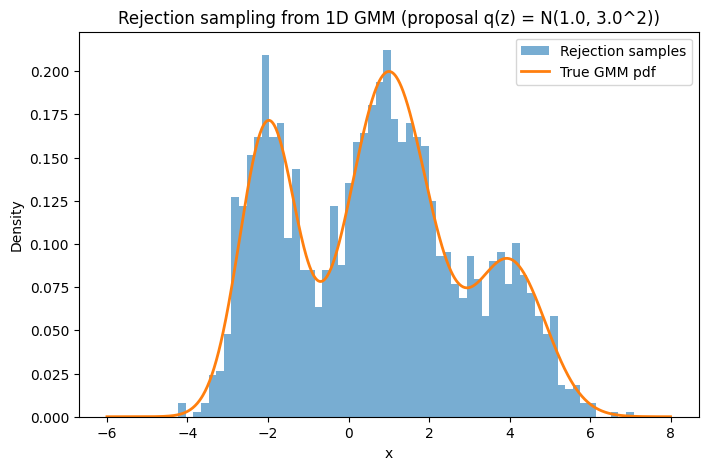

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# True parameters for 3-component GMM
# ------------------------------------------------------------
true_means = np.array([-2.0,  1.0,  4.0])
true_variances = np.array([0.5,  1.0,  0.8])
true_weights = np.array([0.3,  0.5,  0.2])
true_stds = np.sqrt(true_variances)

def normal_pdf(x, mean, std):
    x = np.asarray(x)
    return (1.0 / (np.sqrt(2.0 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

def gmm_pdf(x, means=true_means, stds=true_stds, weights=true_weights):
    """Evaluate the 1-D GMM PDF at points x."""
    x = np.asarray(x)
    pdf_vals = np.zeros_like(x, dtype=float)
    for m, s, w in zip(means, stds, weights):
        pdf_vals += w * normal_pdf(x, m, s)
    return pdf_vals

def proposal_pdf(x, mean=0.0, std=1.0):
    """Proposal density q(x) = N(mean, std^2)."""
    return normal_pdf(x, mean, std)

# ------------------------------------------------------------
# Compute k for rejection sampling with normal proposal q
# ------------------------------------------------------------
def compute_k(proposal_mean=0.0, proposal_std=1.0):
    # grid wide enough to cover mass of both GMM and proposal
    grid = np.linspace(-10, 10, 2000)
    p_vals = gmm_pdf(grid)
    q_vals = proposal_pdf(grid, proposal_mean, proposal_std)

    ratio = p_vals / q_vals
    k = 1.1 * np.max(ratio)  # 10% safety margin
    return k

# ------------------------------------------------------------
# Optimized (vectorized) rejection sampler
# ------------------------------------------------------------
def rejection_sample_gmm(num_samples, proposal_mean=0.0, proposal_std=1.0,
                         seed=0, batch_size=10000):
    """
    Vectorized rejection sampling from the GMM using
    q(z) = N(proposal_mean, proposal_std^2) as proposal.
    - num_samples: number of accepted samples you want
    - batch_size: how many proposals to draw per iteration
    """
    rng = np.random.default_rng(seed)
    k = compute_k(proposal_mean, proposal_std)
    print(f"Computed k: {k:.2f}")
    if k > 1000:
        print("Warning: k is very high. Sampling will be slow. Try increasing proposal_std.")

    samples = []
    total_proposals = 0

    while len(samples) < num_samples:
        # propose a batch from q(z)
        z_batch = rng.normal(loc=proposal_mean, scale=proposal_std, size=batch_size)

        # compute p(z) and q(z) vectorized
        p_batch = gmm_pdf(z_batch)
        q_batch = proposal_pdf(z_batch, proposal_mean, proposal_std)

        # compute acceptance probabilities
        accept_probs = p_batch / (k * q_batch)
        # numerical safety: clip to [0, 1]
        accept_probs = np.clip(accept_probs, 0, 1)

        # accept/reject in one shot
        u = rng.random(batch_size)
        accepted = z_batch[u < accept_probs]

        samples.extend(accepted.tolist())
        total_proposals += batch_size

    samples = np.array(samples[:num_samples])
    accept_rate = num_samples / total_proposals
    print(f"Rejection sampling (vectorized): k ≈ {k:.3f}, acceptance rate ≈ {accept_rate:.4f}")
    return samples

# ------------------------------------------------------------
# Draw samples and plot histogram vs true GMM
# ------------------------------------------------------------
proposal_mean = 1.0
proposal_std = 3.0

samples = rejection_sample_gmm(
    num_samples=2000,
    batch_size=10000,
    proposal_mean=proposal_mean,
    proposal_std=proposal_std
)

x_plot = np.linspace(-6, 8, 1000)
gmm_vals = gmm_pdf(x_plot)

plt.figure(figsize=(8, 5))
plt.hist(samples, bins=60, density=True, alpha=0.6, label="Rejection samples")
plt.plot(x_plot, gmm_vals, label="True GMM pdf", linewidth=2)
plt.xlabel("x")
plt.ylabel("Density")
plt.title(f"Rejection sampling from 1D GMM (proposal q(z) = N({proposal_mean}, {proposal_std}^2))")
plt.legend()
plt.show()

## Part 2

In [ ]:
import math

# ============================================================
# true model and data generation
# ============================================================

# True parameters for generating synthetic data
w_true = np.array([-0.3, 0.5])   # [w0, w1]
noise_variance = 0.04
beta = 1.0 / noise_variance      # precision of likelihood p(t | X, w, beta)

def generate_linear_data(num_points, seed=0):
    """
    Generate synthetic data according to the true linear model:
        t = w0 + w1 * x + epsilon,  epsilon ~ N(0, noise_variance)
    Returns:
        X   : shape (N,)
        t   : shape (N,)
        Phi : design matrix, shape (N, 2) with basis phi(x) = [1, x]^T
    """
    rng = np.random.default_rng(seed)
    X = rng.uniform(-1, 1, size=num_points)
    t = w_true[0] + w_true[1] * X + rng.normal(0, np.sqrt(noise_variance), size=num_points)
    Phi = np.vstack([np.ones(num_points), X]).T  # N x 2
    return X, t, Phi

# Use the SAME training data procedure as Project 2, but only N = 25
N_train = 25
X_train, t_train, Phi_train = generate_linear_data(N_train, seed=42)

# ============================================================
# Log-likelihood (Eq. 3.10) and prior
# ============================================================

def log_likelihood(w, Phi, t, beta):
    """
    Eq. 3.10:
        p(t | X, w, beta) = prod_n N(t_n | w^T phi(x_n), beta^{-1})
    We implement log p(t | X, w, beta).
    """
    y = Phi @ w                 # predicted mean: w^T phi(x_n)
    residuals = t - y
    N = t.shape[0]
    return (
        0.5 * N * (math.log(beta) - math.log(2 * math.pi))
        - 0.5 * beta * np.dot(residuals, residuals)
    )

# Choose a Gaussian prior on w: w ~ N(0, alpha^{-1} I)
alpha_prior = 2.0               # prior precision (can be any reasonable positive value)

def log_prior(w, alpha=alpha_prior):
    """
    log p(w) for w ~ N(0, alpha^{-1} I)
    """
    M = w.shape[0]
    return (
        0.5 * M * (math.log(alpha) - math.log(2 * math.pi))
        - 0.5 * alpha * np.dot(w, w)
    )

def log_posterior(w, Phi, t, beta, alpha=alpha_prior):
    """
    log posterior is proportional to log likelihood + log prior:
        log p(w | X, t) = log p(t | X, w, beta) + log p(w) + const
    We don't need the constant for Metropolis.
    """
    return log_likelihood(w, Phi, t, beta) + log_prior(w, alpha)

# ============================================================
# Metropolis algorithm (Eq. 11.33) for sampling w
# ============================================================

def metropolis_sampling(Phi, t, beta, alpha=alpha_prior,
                        num_iters=20000, proposal_std=0.05, seed=0):
    """
    Random-walk Metropolis sampler for p(w | X, t).
    Proposal: w' = w + epsilon,  epsilon ~ N(0, proposal_std^2 I)

    Eq. 11.33 (Metropolis acceptance):
        a = min(1, p(w') / p(w))
    Implemented in log-space for numerical stability.
    """
    rng = np.random.default_rng(seed)
    M = Phi.shape[1]

    # initialize chain at w = 0
    w_current = np.zeros(M)
    log_post_current = log_posterior(w_current, Phi, t, beta, alpha)

    chain = np.zeros((num_iters, M))
    accepted = 0

    for i in range(num_iters):
        # propose new w'
        w_proposal = w_current + rng.normal(0.0, proposal_std, size=M)

        # compute log posterior at proposal
        log_post_proposal = log_posterior(w_proposal, Phi, t, beta, alpha)

        # log acceptance ratio
        log_alpha = log_post_proposal - log_post_current

        # accept with probability min(1, exp(log_alpha))
        if math.log(rng.random()) < log_alpha:
            w_current = w_proposal
            log_post_current = log_post_proposal
            accepted += 1

        chain[i] = w_current

    accept_rate = accepted / num_iters
    return chain, accept_rate

# Run the MCMC
num_iters = 20000
proposal_std = 0.05
chain, accept_rate = metropolis_sampling(Phi_train, t_train, beta,
                                         num_iters=num_iters,
                                         proposal_std=proposal_std,
                                         seed=0)

print(f"Metropolis acceptance rate: {accept_rate:.3f}")

# ============================================================
# Estimate of weights from the MCMC chain
# ============================================================

burn_in = 5000
w_samples = chain[burn_in:]                # discard early samples
w_estimate = w_samples.mean(axis=0)        # posterior mean estimate

print(f"True w      : {w_true}")
print(f"MCMC mean w : {w_estimate}")


Metropolis acceptance rate: 0.555
True w      : [-0.3  0.5]
MCMC mean w : [-0.25717918  0.50681435]


## Stretch goal: Posterior predictive distribution

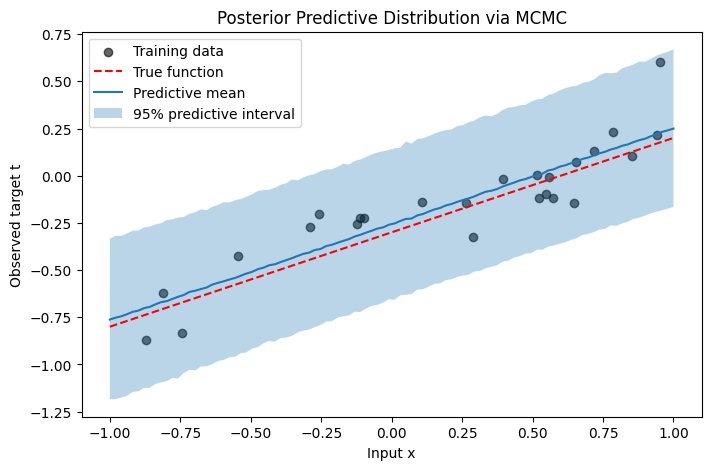

In [ ]:
# ============================================================
# samples from predictive distribution
# ============================================================

# Create test inputs and design matrix
x_test = np.linspace(-1, 1, 100)
# Design matrix with basis phi(x) = [1, x]^T, shape: (N_test, 2)
Phi_test = np.vstack([np.ones_like(x_test), x_test]).T

# Use posterior samples of w to generate latent function predicitive samples f(x) = w^T phi(x)
# w_samples: shape (S, 2)
# Phi_test:  shape (N_test, 2)
f_samples = Phi_test @ w_samples.T # shape (N_test, S) -> each column is one sampled function

# Convert latent f(x) samples into full predictive samples for observed t (includes noise)
# t = f(x) + epsilon,   epsilon ~ N(0, noise_variance)
rng = np.random.default_rng(123)
eps = rng.normal(0, np.sqrt(noise_variance), size=f_samples.shape) # draw noise for every point
t_samples = f_samples + eps   # full posterior predictive samples for observed t with added noise

# Posterior predictive mean and 95% interval for t(x) at each x_test
t_mean = t_samples.mean(axis=1)
t_lower = np.percentile(t_samples, 2.5, axis=1)
t_upper = np.percentile(t_samples, 97.5, axis=1)

# Plot: training data, true function, and posterior predictive band
plt.figure(figsize=(8, 5))

# Training data (observed points)
plt.scatter(X_train, t_train, color='k', alpha=0.6, label="Training data")

# True underlying (noise-free) function
true_line = w_true[0] + w_true[1] * x_test
plt.plot(x_test, true_line, 'r--', label="True function")

# Posterior predictive mean with noise
plt.plot(x_test, t_mean, label="Predictive mean")

# 95% predictive interval for t(x)
plt.fill_between(x_test, t_lower, t_upper, alpha=0.3, label="95% predictive interval")

plt.xlabel("Input x")
plt.ylabel("Observed target t")
plt.title("Posterior Predictive Distribution via MCMC")
plt.legend()
plt.show()